# Metadata

```
Course:   DS 5001
Module:   08 HW
Topic:    Prepare Novels Corpus for LDA
Author:   R.C. Alvarado
```

# Set Up

In [29]:
data_home = '../data'
local_lib = '../lib'
data_prefix = 'novels'
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from nltk.tag import StanfordPOSTagger

# Get the Data

In [3]:
CORPUS = pd.read_csv(f'{data_home}/{data_prefix}/{data_prefix}-CORPUS.csv').set_index(OHCO)

In [65]:
CORPUS.head()

pos     term_str
book_id         chap_id para_num sent_num token_num                  
secretadversary 1       0        1        0           DT          the
                                          1          NNP        young
                                          2          NNP  adventurers
                                          3          NNP          ltd
                        1        0        0           JJ        tommy

# Gather Sentences 

In [4]:
SENTS = CORPUS.groupby(OHCO[:-1]).term_str.apply(lambda x: x.str.cat(sep=' '))

In [66]:
SENTS.head()

book_id     chap_id  para_num  sent_num
adventures  1        0         1                                        a scandal in bohemia
                     1         0                                                           i
                     2         0                  to sherlock holmes she is always the woman
                               1           i have seldom heard him mention her under any ...
                               2           in his eyes she eclipses and predominates the ...
Name: term_str, dtype: object

# Use Stanford POS Tagger

## Method 1: Command Line

In [30]:
# with open(f'{data_home}/output/novels-stanford.csv', 'w') as outfile:
#     outfile.write('\n'.join(SENTS.values))

In [ ]:
# java -Xmx5g edu.stanford.nlp.pipeline.StanfordCoreNLP -file <FILENAME>

## Method 2: Python Library to CoreNLP Server

In [5]:
from nltk.parse import CoreNLPParser

def tag_sents(SENTS):

    pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

    input_sents = [sent.split() for sent in SENTS.values]
    parsed_sents = [pos_tagger.tag(sent) for sent in tqdm(input_sents)]

    TOKEN = pd.DataFrame(parsed_sents, index=SENTS.index).stack().to_frame()
    TOKEN.index.names = OHCO
    TOKEN['term_str'] = TOKEN[0].apply(lambda x: x[0], 1)
    TOKEN['pos'] = TOKEN[0].apply(lambda x: x[1], 1)
    TOKEN = TOKEN.iloc[:, 1:] # Drop first col
    
    return TOKEN

In [8]:
# TOKENS = tag_sents(SENTS)

100%|███████████████████████████████████████████████████████████████████████████| 84282/84282 [06:16<00:00, 224.14it/s]


In [53]:
# TOKENS.pos.value_counts(ascending=True).plot.barh(figsize=(5,15));

# Filter by POS

In [23]:
# BOW = TOKENS.value_counts('term_str').to_frame('n')

In [24]:
BOW

,n
term_str,
the,85329
to,45176
and,44991
of,42638
i,32985
...,...
salutant,1
interwoven,1
salvage,1


In [45]:
NOUNS = TOKENS[TOKENS.pos.isin(['NN','NNS'])]

# Prepare MALLET Source File

* No need to use `ant` to install MALLET!
* Just download and unzip.
* Use Mazo as a wrapper to get started. https://github.com/ontoligent/mazo

In [40]:
def tokens_to_mallet(TOKENS, bag_level=2, label_col=None):
    MALLET = TOKENS.groupby(OHCO[:bag_level]).term_str.apply(lambda x: x.str.cat(sep=' ')).to_frame('doc_str').reset_index()
    MALLET = MALLET[[label_col, 'doc_str']]
    MALLET.index.name = 'doc_id'
    return MALLET

In [46]:
mallet = tokens_to_mallet(NOUNS, 2, 'book_id')

In [49]:
mallet.to_csv(f"./mazo/corpus/{data_prefix}-corpus.csv", index=True, sep=',')

In [52]:
len(mallet)

320

In [51]:
!more mazo/corpus/novels-corpus.csv | wc -l

     321


# Run MALLET

From within `/mazo`, do something like : `python mazo.py novels 40`

# Explore MALLET Results

In [55]:
from glob import glob

In [56]:
# model_path = "novels-60-1648480527812683"
# model_path = "novels-40-16484946450974112"
model_path = "novels-40-1648752368250535"

In [64]:
!ls {model_path}/tables

DOC.csv               TOPIC.csv             TOPICWORD_NARROW.csv
DOCTOPIC.csv          TOPICPHRASE.csv       TOPICWORD_WEIGHTS.csv
DOCTOPIC_NARROW.csv   TOPICWORD.csv         VOCAB.csv
DOCWORD.csv           TOPICWORD_DIAGS.csv


In [57]:
db_schema = dict(
    TOPIC = ['topic_id'],
    TOPICWORD_DIAGS = ['topic_id','word_id'],
    TOPICPHRASE = ['topic_id'],
    DOCTOPIC_NARROW = ['doc_id','topic_id'],
    VOCAB = ['word_id'],
    DOCTOPIC = ['doc_id'],
    TOPICWORD = ['word_id'],
    TOPICWORD_WEIGHTS = ['topic_id', 'word_str'],
    TOPICWORD_NARROW = ['word_id', 'topic_id'],
    DOCWORD = ['doc_id'],
    DOC = ['doc_id']
)

In [58]:
class TM(): pass
tm = TM()
for file_name in glob(f"{model_path}/tables/*.csv"):
    table_name = file_name.split('/')[-1].split('.')[0]
    setattr(tm, table_name, pd.read_csv(file_name).set_index(db_schema[table_name]))

In [59]:
tm.TOPIC['top_phrases'] = tm.TOPICPHRASE.groupby('topic_id').topic_phrase.apply(lambda x: x.str.cat(sep=', ')[:80])

In [62]:
# tm.TOPIC

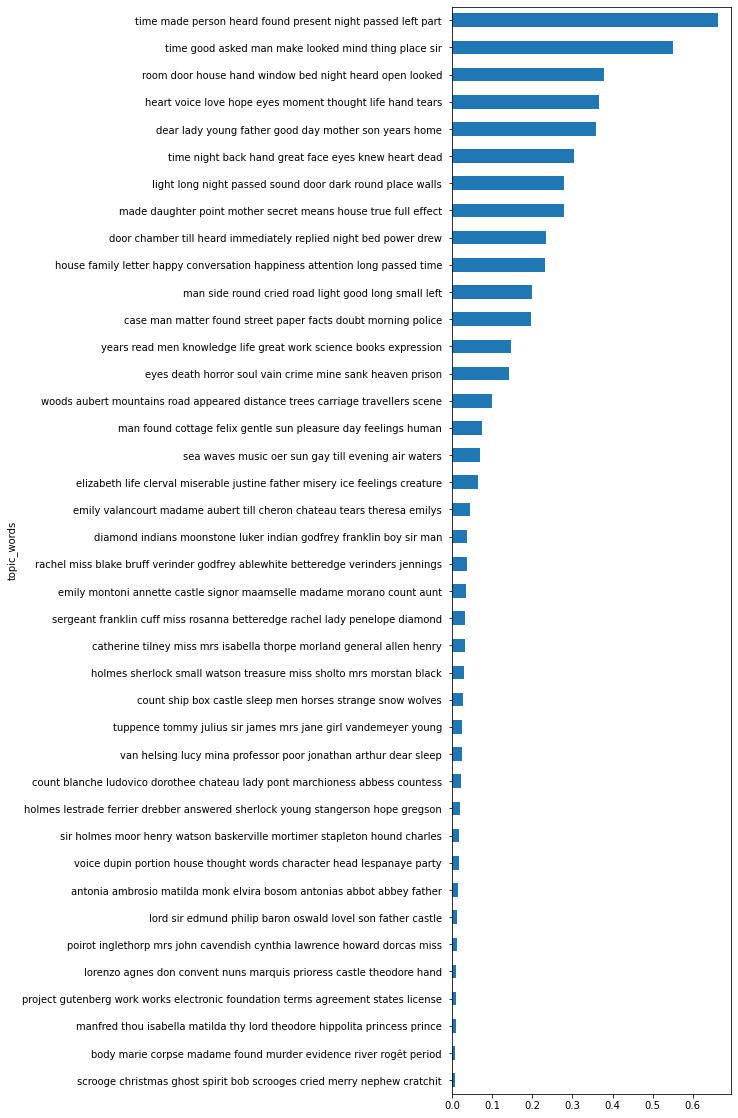

In [61]:
tm.TOPIC.reset_index().set_index('topic_words').topic_alpha.sort_values().plot.barh(figsize=(5,20));

# Save

In [ ]:
TOKEN.to_csv("../data/novels/novels-CORPUS_STANFORD.csv", index=True, sep=',')